In [1]:
# Data management code, scroll to next cell for analysis
import pandas as pd
from pandas import Series,DataFrame

# BLS dataset for labor participation
# http://www.bls.gov/lau/staadata.zip
bls_file = pd.ExcelFile('staadata.xlsx')
# Parse the first sheet of the excel file and set as DataFrame
header = ['FIPS Code', 'State', 'Year', 'Civilian non-institutional population',
           'Civilian labor force Total', 'CLF Percent of population', 'CLF Employment Total',
           'CLF Employment Percent of population', 'CLF Unemployment Total',
           'CLF Unemployment Rate'
          ]
bls = bls_file.parse('Sheet1', skiprows=7, names=header)
bls12 = bls[bls.Year == 2012]
bls12 = bls12[['State','CLF Employment Percent of population','CLF Unemployment Rate']]
bls12['CLF Employment Percent of population'] = pd.to_numeric(bls12['CLF Employment Percent of population'])
bls12['CLF Unemployment Rate'] = pd.to_numeric(bls12['CLF Unemployment Rate'])
bls12.set_index('State')

# 2012 Election data to determine if a state is "red" or "blue"
# http://www.fec.gov/pubrec/fe2012/federalelections2012.shtml
pres_file = pd.ExcelFile('2012pres.xls')
pres = pres_file.parse('2012 Pres General Results')
pres = pres.drop([1, 'FEC ID', 'STATE ABBREVIATION', 'GENERAL ELECTION DATE'], axis=1)
pres.rename(columns={'STATE': 'State',
                     'GENERAL %': 'PercentOfVote'}, inplace=True)
Dem = pres[pres['LAST NAME'] == 'Obama'].set_index('State')
Rep = pres[pres['LAST NAME'] == 'Romney'].set_index('State')
Dem_Rep = pd.DataFrame(Dem['PercentOfVote'] - Rep['PercentOfVote'])
Dem_Rep.rename(columns={'PercentOfVote': 'Percent Obama Over Romney'}, inplace=True)
Dem_Rep.reset_index(level=0, inplace=True)

winner = pres[pres['WINNER INDICATOR'] == 'W']
winner.rename(columns={'LAST NAME': 'Winner'}, inplace=True)
winner = winner[['State','Winner', 'PercentOfVote']]
data = pd.merge(Dem_Rep, winner, left_on='State', right_on='State')
data = data.drop_duplicates('State', keep='first')


# Load income per capita as response variable
# https://en.wikipedia.org/wiki/List_of_U.S._states_by_income
income = pd.read_csv('per_capita_income.csv', low_memory=False)
income.rename(columns={'Per capita\nincome': 'IncomePerCapita'}, inplace=True)
income = income[[1, 2]]
income.set_index('State')
income['IncomePerCapita'] = income['IncomePerCapita'].apply(
    lambda x: x.replace('$', '').replace(',', ''))
income['IncomePerCapita'] = pd.to_numeric(income['IncomePerCapita'])

# Load 2012 SAT score average
# http://www.ipsr.ku.edu/ksdata/ksah/education/
sat_2012 = pd.read_csv('avg_SAT_2012.csv', low_memory=False)
sat_2012 = sat_2012[['State', 'Combined']]
sat_2012.rename(columns={'Combined': 'avg_SAT_2012'}, inplace=True)
sat_2012['avg_SAT_2012'] = pd.to_numeric(sat_2012['avg_SAT_2012'])
sat_2012.set_index('State')

# Merge data sets
data = pd.merge(data, bls12, left_on='State', right_on='State')
data = pd.merge(data, income, left_on='State', right_on='State')
data = pd.merge(data, sat_2012, left_on='State', right_on='State')

data.rename(columns={'CLF Employment Percent of population': 'Labor Participation',
                    'CLF Unemployment Rate': 'Unemployment2012'}, inplace=True)
data['Percent Obama Over Romney'] = pd.to_numeric(data['Percent Obama Over Romney'])
data['Labor Participation'] = pd.to_numeric(data['Labor Participation'])
data['Unemployment2012'] = pd.to_numeric(data['Unemployment2012'])

# 2012 crime data
# http://www.ucrdatatool.gov/Search/Crime/State/RunCrimeOneYearofData.cfm
crime = pd.read_csv('CrimeOneYearofData2012.csv', low_memory=False)
crime = crime[['State', 'Violent Crime rate', 'Property crime rate']]
crime['Violent Crime rate'] = pd.to_numeric(crime['Violent Crime rate'])
crime['Property crime rate'] = pd.to_numeric(crime['Property crime rate'])
data = pd.merge(data, crime, left_on='State', right_on='State')

data_clean = data.copy()
data_clean.head()

/home/titan/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:2748: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


,State,Percent Obama Over Romney,Winner,PercentOfVote,Labor Participation,Unemployment2012,IncomePerCapita,avg_SAT_2012,Violent Crime rate,Property crime rate
0,Alabama,-0.221868,Romney,0.605458,53.4,8.0,23606,1608,449.9,3502.2
1,Alaska,-0.139889,Romney,0.548016,63.4,7.1,33062,1495,603.2,2739.4
2,Arizona,-0.090648,Romney,0.536545,55.5,8.3,25715,1551,428.9,3539.2
3,Arkansas,-0.236879,Romney,0.605669,54.8,7.6,22883,1697,469.1,3660.1
4,California,0.231186,Obama,0.602390,56.6,10.4,30441,1505,423.1,2758.7


In [2]:
predictors = data_clean[['Labor Participation','Unemployment2012',
                               'IncomePerCapita','avg_SAT_2012',
                               'Violent Crime rate','Property crime rate']]
targets = data_clean['Percent Obama Over Romney']

from sklearn import preprocessing
explanatory_vars = DataFrame()
explanatory_vars['Labor Participation']=preprocessing.scale(predictors['Labor Participation'].astype('float64'))
explanatory_vars['Unemployment2012']=preprocessing.scale(predictors['Unemployment2012'].astype('float64'))
explanatory_vars['IncomePerCapita']=preprocessing.scale(predictors['IncomePerCapita'].astype('float64'))
explanatory_vars['avg_SAT_2012']=preprocessing.scale(predictors['avg_SAT_2012'].astype('float64'))
explanatory_vars['Violent Crime rate']=preprocessing.scale(predictors['Violent Crime rate'].astype('float64'))
explanatory_vars['Property crime rate']=preprocessing.scale(predictors['Property crime rate'].astype('float64'))


from sklearn.cross_validation import train_test_split
expla_train, expla_test, tar_train, tar_test = train_test_split(explanatory_vars,
                                                                targets, test_size=.25)
print('Training set: {0}. Testing set: {1}'.format(expla_train.shape, expla_test.shape) )

Training set: (38, 6). Testing set: (13, 6)


In [3]:
# specify the lasso regression model
from sklearn.linear_model import LassoLarsCV
model=LassoLarsCV(cv=10, precompute=False).fit(expla_train,tar_train)

# print variable names and regression coefficients
dict(zip(explanatory_vars.columns, model.coef_))

{'IncomePerCapita': 0.11360917043219973,
 'Labor Participation': 0.0,
 'Property crime rate': 0.0,
 'Unemployment2012': 0.033373659015478355,
 'Violent Crime rate': 0.0,
 'avg_SAT_2012': -0.032617920028919528}

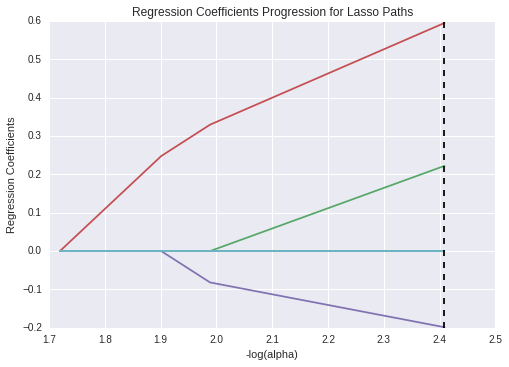

In [4]:
# plot coefficient progression
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sb

m_log_alphas = -np.log10(model.alphas_)
ax = plt.gca()
plt.plot(m_log_alphas, model.coef_path_.T)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.ylabel('Regression Coefficients')
plt.xlabel('-log(alpha)')
plt.title('Regression Coefficients Progression for Lasso Paths')

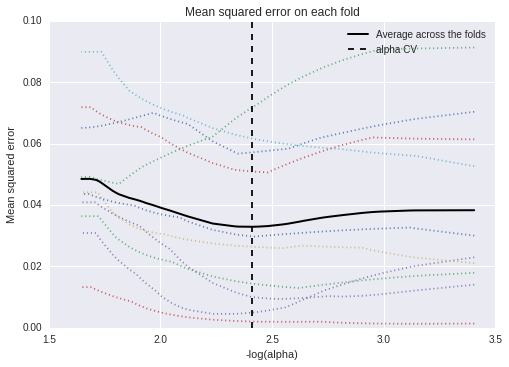

In [5]:
# plot mean square error for each fold
m_log_alphascv = -np.log10(model.cv_alphas_)
plt.figure()
plt.plot(m_log_alphascv, model.cv_mse_path_, ':')
plt.plot(m_log_alphascv, model.cv_mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean squared error')
plt.title('Mean squared error on each fold')

In [6]:
# MSE from training and test data
from sklearn.metrics import mean_squared_error
train_error = mean_squared_error(tar_train, model.predict(expla_train))
test_error = mean_squared_error(tar_test, model.predict(expla_test))
print ('training data MSE')
print(train_error)
print ('test data MSE')
print(test_error)

training data MSE
0.0257645300257
test data MSE
0.0215139020806


In [7]:
# R-square from training and test data
rsquared_train=model.score(expla_train,tar_train)
rsquared_test=model.score(expla_test,tar_test)
print ('training data R-square')
print(rsquared_train)
print ('test data R-square')
print(rsquared_test)

training data R-square
0.438624157357
test data R-square
0.661174293021
